# NeRF: representing scenes as neural radiance fields for view synthesis

NeRF is a method that generates synthesizing novel views of complex scenes by optimizing a sparse set of input views. It is carried out by a fully connected deep network denoted as m, whose input is a single continuous 5D coordinate (location ($x,y,z$) and viewing direction ($\theta, \phi)$) and whose output is the volume density ($\sigma$) and view-dependent emitted radiance ($RGB$) at that spatial location. 
$$
[\sigma,R,G,B]=m([x, y, z, \theta, \phi];\Phi)
$$

![nerf](./figures/illustration_nerf.png)

This neural radiance field represents a scene as the volumne density and directional emitted radiance at any point in space. Given the location and direction of the virtual camera, rendering a 2D image from this model requires estimating the integral $C(r)$ for a camear ray traced through each pixel. This integral consists of volume density $\sigma$, transmittance $T(t)$ and particle on camera ray. 
$$
    C(r)=\int_{t_n}^{t_f}T(t)\sigma(r(t))c(r(t),d)dt,\quad where \quad T(t)=exp(-\int_{t_n}^{t_f}\sigma(r(s))ds)
$$
In this exercise you will learn how to train a NeRF to render yourself in 3D from any angle of camera. Because it is a more difficult project that requires some knowledge of camera, this notebook provides the tutorial about how to generate camera parameters and data needed for training NeRF. 

## Tasks
1. Have a partner take several photos of you standing steadily. Try to cover a wide range of angles and do not move!. Run the preprocessing code, so you generate the ground truth (camera parameters) of your photos
2. Train and optimize MLP to predict the pixel with the given location of the camera and angle. This step is not trivial, and you should start with very small image resolutions to get a feeling for hyperparameters
3. Visualize generated images. 
4. Use YOLO to detect the region of you in the image. And then modify the batch sampling based on the pixels within the bounding box. Experience the difference in accuracy and speed. 

**Important**: At the end, you should write a report of an adequate size, which will likely be at least half a page. In the report, you should describe how you approached the task. You should describe:
- Encountered difficulties (due to the method, e.g., "not enough training samples to converge", not technical like "I could not install a package over pip")
- Steps taken to alleviate difficulties
- General description of what you did, explain how you understood the task, and what you did to solve it in general language, no code.
- Potential limitations of your approach, what could be issues, how could this be hard on different data or with slightly different conditions
- If you have an idea how this could be extended interestingly, describe it.

The packages you need to install before runnning this notebook (If you create your environment as instructed on my github, you already have everthing installed.):

In [ ]:
%pip install opencv-python
%pip install torch
%pip install ipykernel
%pip install imageio
%pip install pillow
%pip install matplotlib
%pip install tqdm

If you have error to install opencv-python, downgrade your python to 3.12. Or use this way to install

```
git clone https://github.com/opencv/opencv-python.git
cd opencv-python
pip install scikit-build setuptools wheel cmake
pip install .
```

Good luck!

In [2]:
import torch
import numpy as np
import json
import os
from PIL import Image
import matplotlib.pyplot as plt
import cv2

## Prerequist of learning NeRF

### Camera model: 

A typical camera cmodel can be represented using a pinhole camera model, where the world scene is projected onto a 2D image plane through a pinhole at the center of the lens. The camera pose is defined by its position and orientation relative to the world coordinate system. As shown in the figure, $Y/Z=y/f$

Given the world coordinate of object $[X,Y,Z]$ and its distance from the pinhole $Z$, the distance between the pinhole and the image plane $f$, the pixel coordinate can be derived by using the triangles argument. 

$$
\begin{bmatrix}
x \\ y\\ z \\
\end{bmatrix}=
\begin{bmatrix}
fX/Z \\ fY/Z \\ f \\
\end{bmatrix}=
\begin{bmatrix}
f &  & & 0\\
 & f &  & 0\\
 &  & 1  & 0\\
\end{bmatrix}
\begin{bmatrix}
X \\ Y \\ Z \\ 1\\
\end{bmatrix}=diga(f,f,1)[I|0] \bold{X}
$$

A principle point $(p_x,p_y)$ is the intersection location of the image plane with the principal axis. The above example assume this principle point is at (0,0). If it is not, the equation expressed in homoegenous coordinates are:
$$
\begin{bmatrix}
fX \\ fY \\ Z \\
\end{bmatrix}=
\begin{bmatrix}
f &  & p_x & 0\\
 & f & p_y & 0\\
 &  & 1  & 0\\
\end{bmatrix}
\begin{bmatrix}
X \\ Y \\ Z \\ 1\\
\end{bmatrix}=K[I|0]
\begin{bmatrix}
X \\ Y \\ Z \\ 1\\
\end{bmatrix}
$$                                                

### camera rotation and translation
![pinhole_model](figures//pinhole%20model%202.png)

Say camera center in Cartesian coordinates is $\tilde C$ and that camera rotation $R$. We can transform a Cartesian point $\tilde{\bold{X}}$ in the world coordinate system to a Cartesian point $\bold{\tilde{X}_{cam}}$ in the camera coordinates system as:
$$
\bold{\tilde{X}_{cam}}=\bold{R}(\tilde{\bold{X}}-\tilde{\bold{C}}) =
\begin{bmatrix}
\bold{R} & -\bold{R\tilde{C}} \\
0 & 1\\
\end{bmatrix}
\begin{bmatrix}X \\Y\\Z\\1\end{bmatrix}
$$
Denote $\bold{t}=-\bold{R\tilde{C}}$. We can see the final image coordinate is:
$$
x=\bold{K[R|t]X}
$$

$\bold{K}$ is intrinsics matrix which describe the internal parameters of the camera that relate the 3D world coordinates to 2D image coordinates. It constains focal length, principal point and pixel aspect ratio (1 if pixels are square)

$\bold{[R|t]}$ is the extrinsic matrix which desribes the transformation from world coordinates to camera coordinates.

### Example from NeRF public dataset: lego

Download example dataset from: https://www.kaggle.com/datasets/nguyenhung1903/nerf-synthetic-dataset

unzip the file and choise one folder to learn how to load camera parameters and image. Change the name of ```base_dir``` according to your choice. 

In [10]:
import torch
import numpy as np
import json
import os
from PIL import Image
import matplotlib.pyplot as plt
import cv2

# data path
base_dir = "datasets/nerf_synthetic/lego"
# reduce the resolution by factor
factor = 4
# load camera intrinsic and extrinsic parameters from json file
with open(os.path.join(base_dir, 'transforms_{}.json'.format('train')), 'r') as fp:
    meta = json.load(fp)
images = []
cams = []
for i in range(len(meta['frames'])):
    frame = meta['frames'][0]
    fname = os.path.join(base_dir, frame['file_path'] + '.png')
    with open(fname, 'rb') as imgin:
        image = np.array(Image.open(imgin), dtype=np.float32) / 255.
        if factor >= 2:
            [halfres_h, halfres_w] = [hw // factor for hw in image.shape[:2]]
            image = cv2.resize(
                image, (halfres_w, halfres_h), interpolation=cv2.INTER_AREA)
    cams.append(np.array(frame['transform_matrix'], dtype=np.float32))
    images.append(image)
images = np.stack(np.array(images), axis=0)
print('Number of images, width, height, channels:', images.shape)

Number of images, width, height, channels: (100, 200, 200, 4)


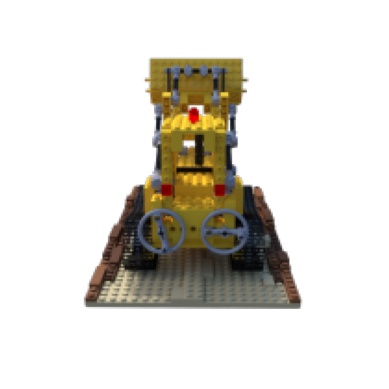

In [11]:
plt.imshow(images[0,:,:,:])
plt.axis('off')
plt.show()

In [12]:
H, W = images.shape[1:3]
cam_to_world=cams[0]
camera_angle_x=float(meta['camera_angle_x']) # angle of field of view in x direction
focal = .5 * W / np.tan(.5 * camera_angle_x)
n_poses=images.shape[0]
print('Focal length:', focal)
print('Number of poses:', n_poses) 
print('Image height:', H)
print('Image width:', W)
print('Camera to world matrix ([R|t], extrinsic matrix) of first image:\n', cam_to_world)
print('Camera view of angle x (degree):', camera_angle_x*180/np.pi)

Focal length: 277.77775779844205
Number of poses: 100
Image height: 200
Image width: 200
Camera to world matrix ([R|t], extrinsic matrix) of first image:
 [[-9.9990219e-01  4.1922452e-03 -1.3345719e-02 -5.3798322e-02]
 [-1.3988681e-02 -2.9965907e-01  9.5394367e-01  3.8454704e+00]
 [-4.6566129e-10  9.5403719e-01  2.9968831e-01  1.2080823e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  1.0000000e+00]]
Camera view of angle x (degree): 39.597755335771296


### Q1: How do we generate input and ground true for supervise learning?

![overview_nerf](./figures/nerf_overview.png)

Given set of images, algorithms such as structure-from-motion (COLMAP) can estimate camera poses, intrinsics and bouds. With these parameters, pixel RGB values its corresponding camera poses, view direction are stored as target y and input x, respectively.
For example, an image (2x2) generate 4 training samples: 
$$
\begin{bmatrix}
xc & yc & zc & \theta_1 & \phi_1 & R1 & G1 & B1 \\
xc & yc & zc & \theta_2 & \phi_2 & R2 & G2 & B2 \\
xc & yc & zc & \theta_3 & \phi_3 & R3 & G3 & B3 \\
xc & yc & zc & \theta_4 & \phi_4 & R4 & G4 & B4 
\end{bmatrix}
$$

Since matrix multiplication is easier with 3D Cartesian unit vectors, the view direction is expressed as [d1,d2,d3]. So the size of the dataset eventually is (4,9)


### Run your own data steps:
- Install [COLMAP](https://github.com/colmap/colmap) following [installation guide](https://colmap.github.io/install.html)
- Prepare your images in a folder (around 20 to 30 for forward facing, and 40 to 50 for 360 inward-facing)
- Clone [LLFF] and run ```python img2poses.py $your-images-folder```

In [ ]:
# if you run your file correctly, you should be able to divide the results to three folder: training, test, val and saved as three pkl files
# TODO: 
# training_dataset = torch.load('training_dataset_your_own.pkl')
# testing_dataset = torch.load('testing_dataset_your_own.pkl')
# validation_dataset = torch.load('validation_dataset_your_own.pkl')

### Genrate rays for NeRF training
 Since the ground true we have are the pixels from 2D images, we need to accumualte preditions on 3D space along the ray that pass the center of camera to the pixel. First, we calcaulte all pixel's world coordinates and the its direction from the camera center. Then we store the directions of pixels, origins of camera and viewdirs represented in world frame. 

In [13]:
near= 2.0 # object in the scene is between near and far plane
far= 6.0
x, y = np.meshgrid(
    np.arange(W, dtype=np.float32),  # X-Axis (columns)
    np.arange(H, dtype=np.float32),  # Y-Axis (rows)
    indexing='xy')

camera_directions = np.stack(
    [(x - W * 0.5 + 0.5) / focal,
    -(y - H * 0.5 + 0.5) / focal,
    -np.ones_like(x)],
    axis=-1) # 400x400x3

# Rotate ray directions from camera frame to the world frame
directions = ((camera_directions[..., None, :] * cam_to_world[None, None, :3, :3]).sum(axis=-1))  # Translate camera frame's origin to the world frame
origins = np.broadcast_to(cam_to_world[None, None, :3, -1], directions.shape)
viewdirs = directions / np.linalg.norm(directions, axis=-1, keepdims=True)
print(origins.shape, directions.shape, viewdirs.shape)

(200, 200, 3) (200, 200, 3) (200, 200, 3)


### Q2: How to render (predict) a new image with given position and view direction of camera?
The output of model is not directly the color of each pixel, it is the density and color at 3D spatial position. To project 3D radiant onto a 2D image, rendering algorithm is applied. As illustrated in figure 2, discretilization is needed to numerically estiamte equation 1. This invloves queried several points on the ray and limit the speed of rendering. We can see better methods to do volume rendering. Here we desmonstrate the original one proposed by the paper: partition $[t_n, t_f]$ into N evenly spaced bins and then draw one sample $t_i$ uniformly at random from within each bin.

$$
t_i \sim u\left[t_n + \frac{i-1}{N}(t_f - t_n),\;\; t_n + \frac{i}{N}(t_f - t_n)\right]
$$

In [ ]:
hn=0
hf=0.5
nb_bins=10

ray_origins = training_dataset[img_index * H * W: (img_index + 1) * H * W, :3][0]
ray_directions = training_dataset[img_index * H * W: (img_index + 1) * H * W, 3:6][0]

t = torch.linspace(hn, hf, nb_bins).expand(ray_origins.shape[0], nb_bins)
# Perturb sampling along each ray.
mid = (t[:, :-1] + t[:, 1:]) / 2.
lower = torch.cat((t[:, :1], mid), -1)
upper = torch.cat((mid, t[:, -1:]), -1)
u = torch.rand(t.shape)
t = lower + (upper - lower) * u  # [batch_size, nb_bins]
delta = torch.cat((t[:, 1:] - t[:, :-1], torch.tensor([1e10],).expand(ray_origins.shape[0], 1)), -1)

x = ray_origins.unsqueeze(1) + t * ray_directions.unsqueeze(1)  
print(f"Sampled 3D points along a ray:\n {x.transpose(1,0)}")

Estimating C(r) with quadrature rule is given as:

$$
\hat{C}(r)=\sum_{i=1}^{N}T_i(1-\exp{(-\sigma_i \delta_i)})c_i \\
T_i=\exp{(-\sum_{j=1}^{i-1}\sigma_j \delta_j)},
$$

where $\delta_i=t_{i+1}-t_i$ is the distance between adjacent samples
This function can reduces to traidtional alpha compositing with alpha values:
$$
\alpha_i=1-\exp{(-\sigma_i \delta_i)} \\
\hat{C}(r)=\sum_{i=1}^{N} T_i \alpha_i c_i 
$$

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

L = 16
F = 2
T = 2**19
N_min = 16
N_max = 2048
b = np.exp((np.log(N_max) - np.log(N_min)) / (L - 1))
Nl = [int(np.floor(N_min * b**l)) for l in range(L)]

In [ ]:
def compute_accumulated_transmittance(alphas):
    accumulated_transmittance = torch.cumprod(alphas, 1)
    return torch.cat((torch.ones((accumulated_transmittance.shape[0], 1), device=alphas.device),
                      accumulated_transmittance[:, :-1]), dim=-1)

def render_rays(nerf_model, ray_origins, ray_directions, hn=0, hf=0.5, nb_bins=192):
    device = ray_origins.device
    t = torch.linspace(hn, hf, nb_bins, device=device).expand(ray_origins.shape[0], nb_bins)
    # Perturb sampling along each ray.
    mid = (t[:, :-1] + t[:, 1:]) / 2.
    lower = torch.cat((t[:, :1], mid), -1)
    upper = torch.cat((mid, t[:, -1:]), -1)
    u = torch.rand(t.shape, device=device)
    t = lower + (upper - lower) * u  # [batch_size, nb_bins]
    delta = torch.cat((t[:, 1:] - t[:, :-1], torch.tensor(
        [1e10], device=device).expand(ray_origins.shape[0], 1)), -1)

    # Compute the 3D points along each ray
    x = ray_origins.unsqueeze(1) + t.unsqueeze(2) * ray_directions.unsqueeze(1)
    # Expand the ray_directions tensor to match the shape of x
    ray_directions = ray_directions.expand(nb_bins, ray_directions.shape[0], 3).transpose(0, 1)
    colors, sigma = nerf_model(x.reshape(-1, 3), ray_directions.reshape(-1, 3))
    alpha = 1 - torch.exp(-sigma.reshape(x.shape[:-1]) * delta)  # [batch_size, nb_bins]
    weights = compute_accumulated_transmittance(1 - alpha).unsqueeze(2) * alpha.unsqueeze(2)
    c = (weights * colors.reshape(x.shape)).sum(dim=1)
    weight_sum = weights.sum(-1).sum(-1)  # Regularization for white background
    return c + 1 - weight_sum.unsqueeze(-1)

Positioning encoding is applied to 5D input in order to represent high-frequency variation in color and geometry. 
The authors designed separate MLPs to predict density and emitted color. The first MLP predicts the volume density as a function of only the location x, while allowing the RGB color c to be predicted as a function of both location and viewing direction. Now we pack all these functions into NerfModel class

In [ ]:
class NerfModel(nn.Module):
    def __init__(self, embedding_dim_pos=10, embedding_dim_direction=4, hidden_dim=128):   
        super(NerfModel, self).__init__()
        
        self.block1 = nn.Sequential(nn.Linear(embedding_dim_pos * 6 + 3, hidden_dim), nn.ReLU(),
                                    nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
                                    nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
                                    nn.Linear(hidden_dim, hidden_dim), nn.ReLU(), )
        # density estimation
        self.block2 = nn.Sequential(nn.Linear(embedding_dim_pos * 6 + hidden_dim + 3, hidden_dim), nn.ReLU(),
                                    nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
                                    nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
                                    nn.Linear(hidden_dim, hidden_dim + 1), )
        # color estimation
        self.block3 = nn.Sequential(nn.Linear(embedding_dim_direction * 6 + hidden_dim + 3, hidden_dim // 2), nn.ReLU(), )
        self.block4 = nn.Sequential(nn.Linear(hidden_dim // 2, 3), nn.Sigmoid(), )

        self.embedding_dim_pos = embedding_dim_pos
        self.embedding_dim_direction = embedding_dim_direction
        self.relu = nn.ReLU()

    @staticmethod
    def positional_encoding(x, L):
        out = [x]
        for j in range(L):
            out.append(torch.sin(2 ** j * x))
            out.append(torch.cos(2 ** j * x))
        return torch.cat(out, dim=1)

    def forward(self, o, d):
        emb_x = self.positional_encoding(o, self.embedding_dim_pos) # emb_x: [batch_size, embedding_dim_pos * 6]
        emb_d = self.positional_encoding(d, self.embedding_dim_direction) # emb_d: [batch_size, embedding_dim_direction * 6]
        h = self.block1(emb_x) # h: [batch_size, hidden_dim]
        tmp = self.block2(torch.cat((h, emb_x), dim=1)) # tmp: [batch_size, hidden_dim + 1]
        h, sigma = tmp[:, :-1], self.relu(tmp[:, -1]) # h: [batch_size, hidden_dim], sigma: [batch_size]
        h = self.block3(torch.cat((h, emb_d), dim=1)) # h: [batch_size, hidden_dim // 2]
        c = self.block4(h) # c: [batch_size, 3]
        return c, sigma

In [ ]:
# TODO Training Loop

### Test your model 

To understand the use of NeRF in rendering scene, here we load a trained NeRF model and run the test images for demonstration. You can not run this part if you don't have a save model named "nerf_model.pth"

In [ ]:

#load model to estimate density and color at 3D spatial position
model = NerfModel(hidden_dim=256).to(device)
model.load_state_dict(torch.load('../models/nerf_model.pth'))
model.eval()
model.to(device)

hn,hf=2,6
chunk_size=20
for img_index in range(2):
    ray_origins = testing_dataset[img_index * H * W: (img_index + 1) * H * W, :3]
    ray_directions = testing_dataset[img_index * H * W: (img_index + 1) * H * W, 3:6]

    px_values = []   # list of regenerated pixel values
    for i in range(int(np.ceil(H / chunk_size))):   # iterate over chunks
        ray_origins_ = ray_origins[i * W * chunk_size: (i + 1) * W * chunk_size].to(device)
        ray_directions_ = ray_directions[i * W * chunk_size: (i + 1) * W * chunk_size].to(device)
        px_values.append(render_rays(model, ray_origins_, ray_directions_,
                                     hn=hn, hf=hf, nb_bins=nb_bins))
    img = torch.cat(px_values).data.cpu().numpy().reshape(H, W, 3)
    img = (img.clip(0, 1)*255.).astype(np.uint8)
    img_rendered = Image.fromarray(img)


    # Ground truth image from testing_dataset
    img_gt = testing_dataset[img_index * H * W : (img_index + 1) * H * W, 6:]
    img_gt = img_gt.reshape(H, W, 3)

    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes[0].imshow(img_rendered)
    axes[0].set_title("Rendered Image")
    axes[0].axis('off')

    axes[1].imshow(img_gt)
    axes[1].set_title("Ground Truth Image")
    axes[1].axis('off')

    plt.show()

In [ ]:
# TODO Visualization
# -------------------
# Instructions:
# - After training, visualize some generated images.